a) Demonstrate how convolution layers themselves work visually in colab

 building a high-performance vision classifier using TensorFlow and Keras.

TPU detected and initialized


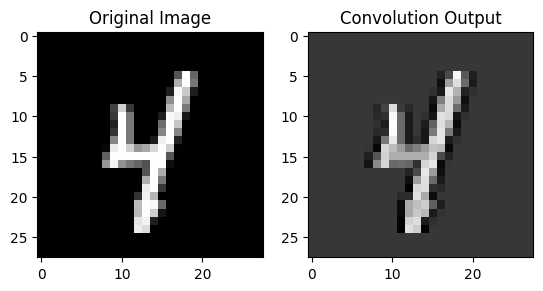

In [ ]:
import os
import tensorflow as tf

# Detect TPU and set up the distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized")
except ValueError:
    strategy = tf.distribute.get_strategy()
    print("No TPU detected, using default strategy")

# Set batch size and number of epochs
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 10

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D

def visualize_convolution(image, kernel):
    conv_layer = Conv2D(1, kernel_size=3, padding="same", use_bias=False, kernel_initializer=tf.keras.initializers.Constant(kernel))
    conv_output = conv_layer(image[None, ..., None]).numpy().squeeze()

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original Image")
    axes[1].imshow(conv_output, cmap="gray")
    axes[1].set_title("Convolution Output")
    plt.show()

# Load a sample image from TensorFlow datasets
import tensorflow_datasets as tfds
ds, _ = tfds.load("mnist", split="train", as_supervised=True, with_info=True, try_gcs=True)
sample_image = next(iter(ds.take(1)))[0].numpy().astype(np.float32) / 255

# Define a sample kernel
sample_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# Visualize the convolution operation
visualize_convolution(sample_image, sample_kernel)


b) Implement a depthwise pooling layer in Keras and demonstrate its use:

1/1 [==============================] - 0s 255ms/step


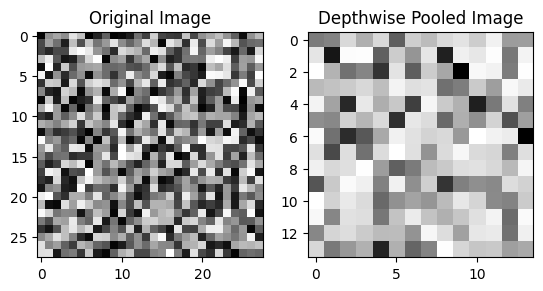

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class DepthwisePooling(Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(DepthwisePooling, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        import tensorflow as tf  # Add this line to import TensorFlow

        input_shape = tf.shape(inputs)
        batch_size, height, width, channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        pool_h, pool_w = self.pool_size

        # Reshape the input tensor to prepare for depthwise pooling
        new_height, new_width = height // pool_h, width // pool_w
        reshaped_input = tf.reshape(inputs, (batch_size, new_height, pool_h, new_width, pool_w, channels))

        # Perform depthwise pooling
        pooled = tf.reduce_max(reshaped_input, axis=(2, 4))

        return pooled


# Test the custom DepthwisePooling layer
input_shape = (28, 28, 1)
inputs = Input(input_shape)
x = DepthwisePooling(pool_size=(2, 2))(inputs)
model = Model(inputs=inputs, outputs=x)

# Test the custom DepthwisePooling layer
test_image = np.random.random((1, *input_shape))
pooled_image = model.predict(test_image)

# Visualize the result
fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_image[0, ..., 0], cmap="gray")
axes[0].set_title("Original Image")
axes[1].imshow(pooled_image[0, ..., 0], cmap="gray")
axes[1].set_title("Depthwise Pooled Image")
plt.show()



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.utils import to_categorical
# Load the dataset
(dataset_train, labels_train), (dataset_test, labels_test) =  fashion_mnist.load_data()  

# Preprocess the data
dataset_train = dataset_train.astype('float32') / 255
dataset_test = dataset_test.astype('float32') / 255

if len(dataset_train.shape) == 3:
    dataset_train = np.expand_dims(dataset_train, axis=-1)
    dataset_test = np.expand_dims(dataset_test, axis=-1)

# One-hot encode the labels
labels_train = to_categorical(labels_train, 10)
labels_test = to_categorical(labels_test, 10)


4422102/4422102 [==============================] - 0s 0us/step


Create the simple neural network and LeNet-5 models:

In [ ]:
# Simple Neural Network
def simple_nn(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# LeNet-5
def lenet_5(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


In [ ]:
input_shape = dataset_train.shape[1:]
num_classes = 10

# Train and evaluate Simple Neural Network
simple_nn_model = simple_nn(input_shape, num_classes)
simple_nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_nn_model.fit(dataset_train, labels_train, epochs=10, batch_size=128, validation_split=0.2)
simple_nn_score = simple_nn_model.evaluate(dataset_test, labels_test)

print("Simple Neural Network Test Loss:", simple_nn_score[0])
print("Simple Neural Network Test Accuracy:", simple_nn_score[1])

# Train and evaluate LeNet-5
lenet_5_model = lenet_5(input_shape, num_classes)
lenet_5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lenet_5_model.fit(dataset_train, labels_train, epochs=10, batch_size=128, validation_split=0.2)
lenet_5_score = lenet_5_model.evaluate(dataset_test, labels_test)

print("LeNet-5 Test Loss:", lenet_5_score[0])
print("LeNet-5 Test Accuracy:", lenet_5_score[1])



Epoch 1/10
375/375 [==============================] - 6s 8ms/step - loss: 0.5720 - accuracy: 0.8056 - val_loss: 0.4674 - val_accuracy: 0.8384
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.4089 - accuracy: 0.8568 - val_loss: 0.3937 - val_accuracy: 0.8631
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3690 - accuracy: 0.8697 - val_loss: 0.3741 - val_accuracy: 0.8689
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3448 - accuracy: 0.8769 - val_loss: 0.3552 - val_accuracy: 0.8725
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.3233 - accuracy: 0.8834 - val_loss: 0.3420 - val_accuracy: 0.8792
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.3062 - accuracy: 0.8891 - val_loss: 0.3370 - val_accuracy: 0.8788
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2943 - accuracy: 0.8936 - val_loss: 0.3373 - val_accuracy: 0.8786
Epoch 